In [1]:
import torch

from botorch.test_functions.multi_objective import BraninCurrin
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective import is_non_dominated

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def empirical_cdf(x):
    xs = torch.sort(x)
    ys = torch.arange(1, len(xs.values) + 1) / float(len(xs.values))
    return ys[torch.sort(xs.indices).indices]

def plot_distribution(
    grid_spec, number, Y, limit, title, legend=False, transform=False
):

    i1 = 0
    i2 = i1 + 3
    i3 = 5 * number
    i4 = i3 + 1
    i5 = i3 + 4

    Yp = Y[is_non_dominated(Y)]
    ax = fig.add_subplot(gs[i1:i2, i4:i5])
    ax.scatter(Y[:, 0], Y[:, 1], color="dodgerblue", alpha=0.1, label="Objective", s=50)
    ax.scatter(Yp[:, 0], Yp[:, 1], color="crimson", alpha=1, label="Pareto front", s=50)

    ax_y = fig.add_subplot(gs[i1:i2, i3])
    ax_y.hist(
        Y[:, 1].detach().numpy(),
        bins=80,
        density=True,
        orientation="horizontal",
        color="dodgerblue",
        edgecolor="black",
        linewidth=0.01,
    )

    ax_x = fig.add_subplot(gs[i2, i4:i5])
    ax_x.hist(
        Y[:, 0].detach().numpy(),
        bins=80,
        density=True,
        color="dodgerblue",
        edgecolor="black",
        linewidth=0.01,
    )

    ax.set_xlim(limit)
    ax.set_ylim(limit)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=40)
    if legend:
        ax.legend(fontsize=35)

    ax_x.set_xlim(limit)
    ax_y.set_ylim(limit)

    if transform:
        ax_x.set_xlabel(r"$\tau^{(1)}(f(\mathbf{x}))$", fontsize=35)
        ax_y.set_ylabel(r"$\tau^{(2)}(f(\mathbf{x}))$", fontsize=35)
    else:
        ax_x.set_xlabel(r"$f^{(1)}(\mathbf{x})$", fontsize=35)
        ax_y.set_ylabel(r"$f^{(2)}(\mathbf{x})$", fontsize=35)

    ax_x.tick_params("both", labelsize=30)
    ax_y.tick_params("both", labelsize=30)

    ax_x.set_yticks([])
    ax_y.set_xticks([])
    return

In [3]:
torch.manual_seed(1)
# get initial data
tkwargs = {
    "dtype": torch.double,
    "device": "cpu",
}
problem = BraninCurrin(negate=True).to(**tkwargs)
bounds = problem.bounds
num_initial = 100000
initial_X = draw_sobol_samples(bounds=bounds, n=num_initial, q=1).squeeze(-2)
initial_Y = problem(initial_X)

up_Y = torch.max(initial_Y, dim=0).values
low_Y = torch.min(initial_Y, dim=0).values
normalized_Y = (initial_Y - low_Y) / (up_Y - low_Y)

initial_lim = [-310, 10]
normalized_lim = [-0.05, 1.05]

ecdf_Y = torch.column_stack(
    [empirical_cdf(normalized_Y[:, 0]), empirical_cdf(normalized_Y[:, 1])]
)

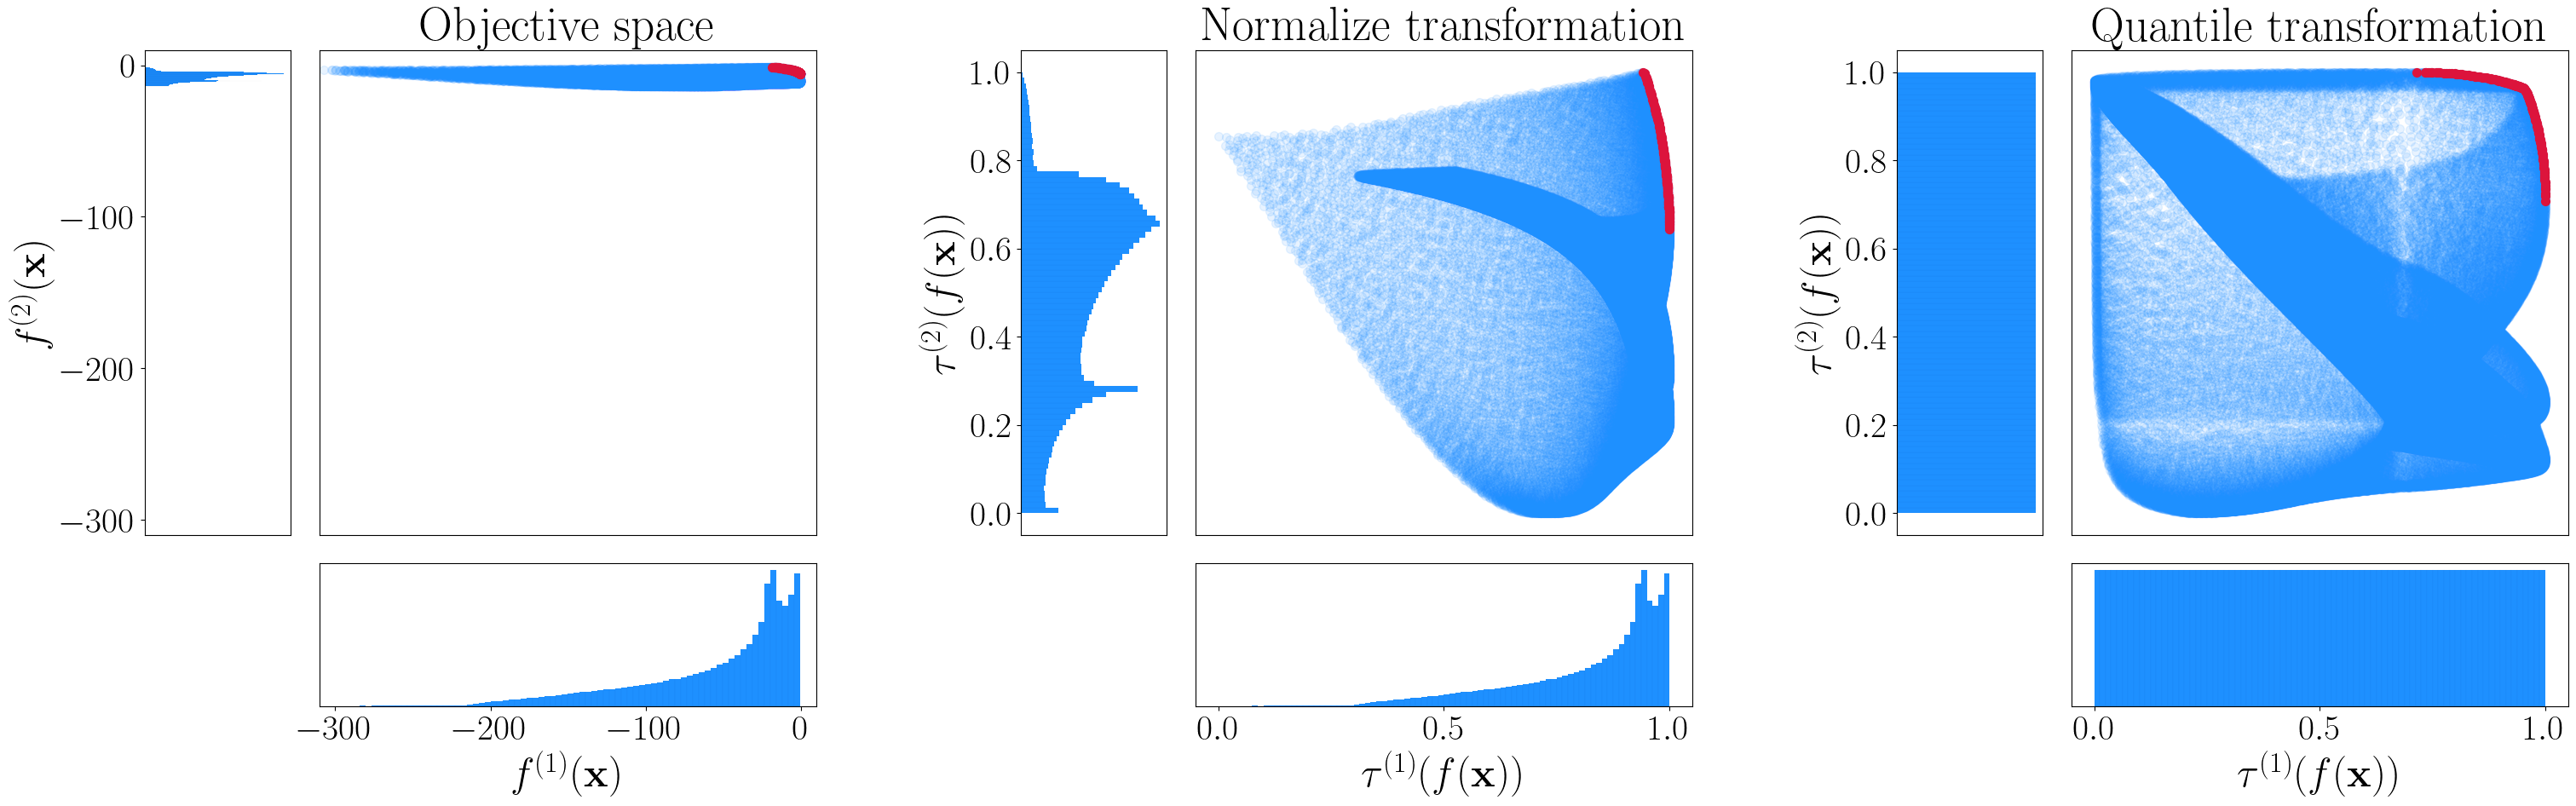

In [4]:
fig = plt.figure(figsize=(42, 10), rasterized=True)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2
)
gs = gridspec.GridSpec(4, 16)
plot_distribution(
    grid_spec=gs,
    number=0,
    Y=initial_Y,
    limit=initial_lim,
    title=r"Objective space",
    legend=False,
    transform=False,
)

plot_distribution(
    grid_spec=gs,
    number=1,
    Y=normalized_Y,
    limit=normalized_lim,
    title=r"Normalize transformation",
    legend=False,
    transform=True,
)

plot_distribution(
    grid_spec=gs,
    number=2,
    Y=ecdf_Y,
    limit=normalized_lim,
    title=r"Quantile transformation",
    legend=False,
    transform=True,
)

plt.show()